In [1]:
import gzip
import io
import sys
import time
import unittest
from typing import List
from Point import Point
from TimeSeriesReader import TimeSeriesReader
from datetime import datetime, timedelta
from utilFunction import *
import TestPLA 
from SimPiece import SimPiece
from TestPLA import *
sys.path.append('/home/guoyou/ExtractSemantic/Data/')
path = '/home/guoyou/ExtractSemantic/Data/'

In [2]:
filenames = ["Cricket.csv.gz", "FaceFour.csv.gz", "Lightning.csv.gz", "MoteStrain.csv.gz", "Wafer.csv.gz", "WindSpeed.csv.gz", "WindDirection.csv.gz", "Pressure.csv.gz"]
filename = filenames[0]

delimiter = ","
with open(path+filename, 'rb') as inputStream:
    print(filename)
    ts = TimeSeriesReader.getTimeSeries(inputStream, delimiter, True)

Cricket.csv.gz


### 1、对原始数据进行处理，获取Base

In [14]:
epsilonPct = 0.05
PLA = TestPLA()
#compressedSize = PLA.PicewiseSegment( ts.data, epsilonPct, False, False) # strict error threhold
compressedSize = PLA.PicewiseSegment( ts.data, ts.range * epsilonPct, False, False) # range error threhold
#print(f"Epsilon: {epsilonPct * 100:.2f}%\tCompression Ratio: {ts.size / compressedSize:.3f}\tExecution Time: {PLA.duration}ms")
print(f"Epsilon: {epsilonPct * 100:.2f}%\tCompression Ratio: {ts.size / compressedSize:.3f}\tExecution Time: {PLA.duration}ms\tRange Error: {ts.range * epsilonPct:.3f}")

Epsilon: 0.10%	Compression Ratio: 4.534	Execution Time: 2260ms	Range Error: 0.023


In [4]:
tsDecompressed = PLA.tsDecompressed
residuals =  [Point(p1.timestamp, p1.value - p2.value) for p1, p2 in zip( ts.data, PLA.tsDecompressed)]

In [5]:
len(residuals )

702000

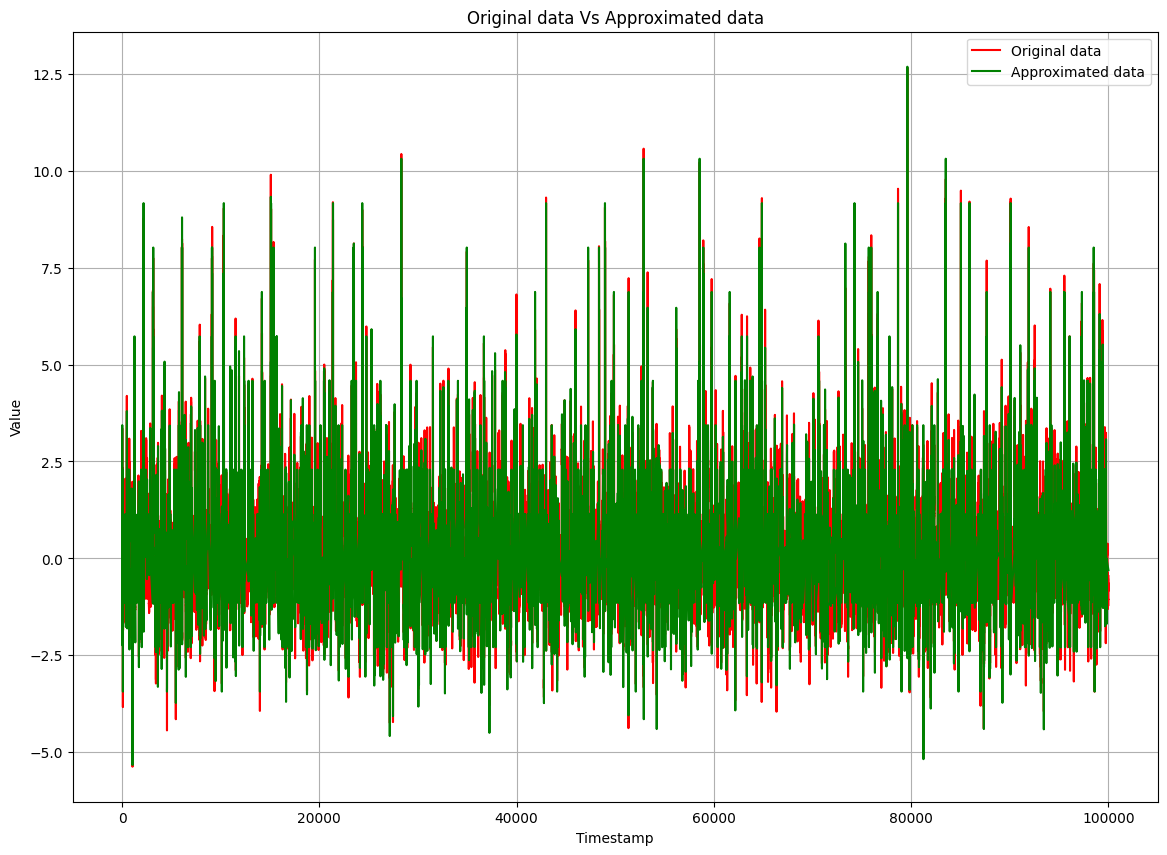

In [6]:
plot_two_line_graphs(ts.data, tsDecompressed, end =100000, title="Original data Vs Approximated data")

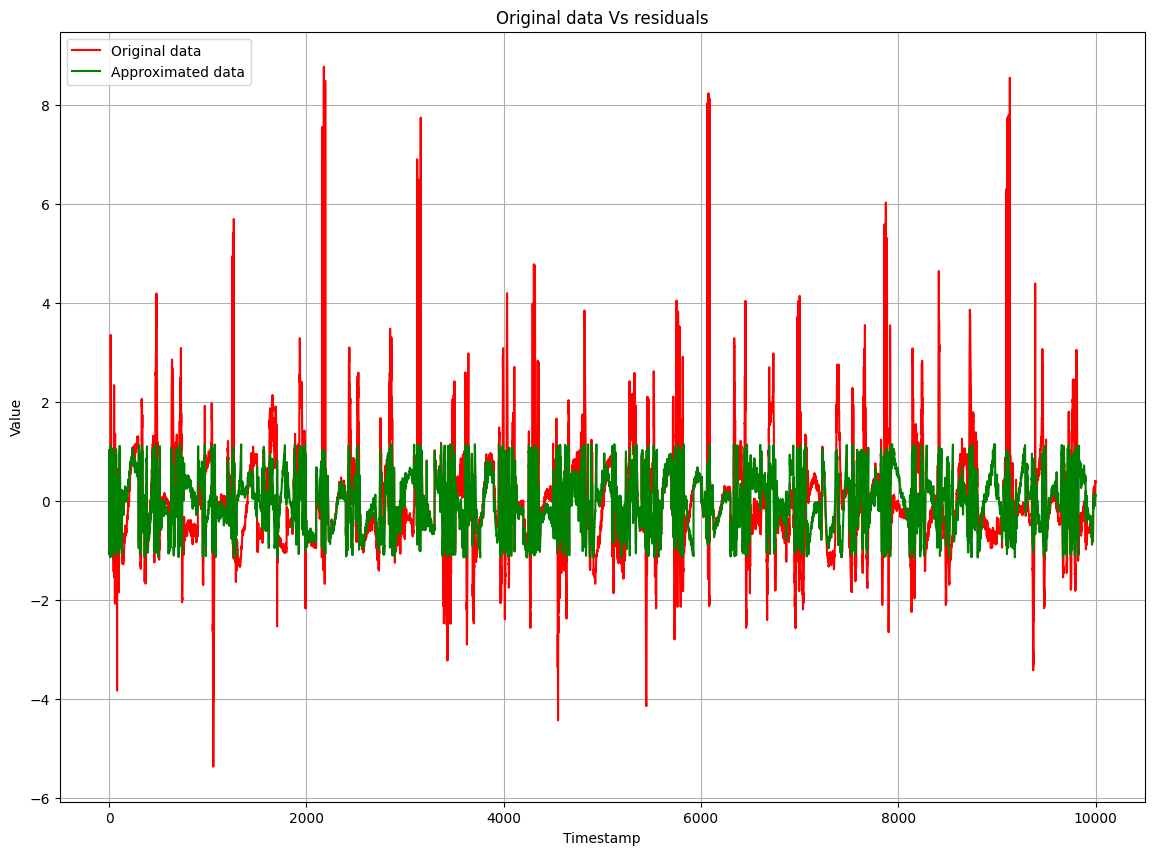

In [7]:
plot_two_line_graphs(ts.data, residuals, end =10000, title="Original data Vs residuals")

### 2、测试Entropy Coding

In [8]:
residuals_value  = [p.value for p in residuals]
print(residuals_value[:10])

[-0.11786119963836672, -1.0872484807280731, 0.6536136681822204, 1.006175227092514, -0.3329590196383667, -0.3026674173704338, -0.48303729510250093, -0.429588072834568, -0.5303243205666351, -0.7270611182987022]


In [9]:
import csv


# 指定CSV文件的路径
csv_file_path = "/home/guoyou/data/residuals.csv"

with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # 将列表中的每个元素作为一行写入CSV文件
    for item in residuals_value:
        csv_writer.writerow([item])

print(f"数据已保存到 {csv_file_path}")


数据已保存到 /home/guoyou/data/residuals.csv


In [10]:
print("max = ", max(residuals_value ) )
print("min= ", min(residuals_value ) )
print("length of residuals = ", len(residuals_value))

max =  1.1453012428921223
min=  -1.145300862660494
length of residuals =  702000


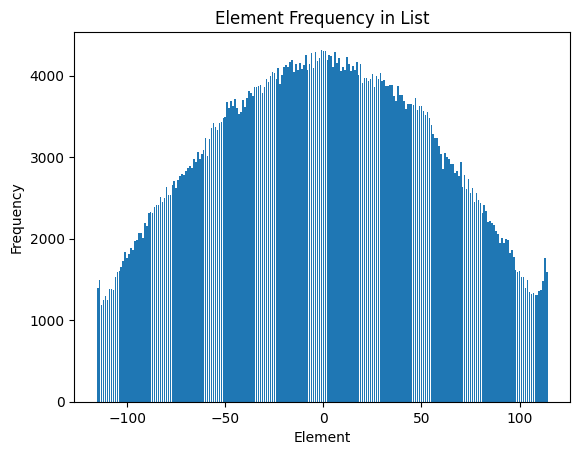

In [12]:
import math
quantizi_residuals = [ math.floor(v/0.01) for v in residuals_value]
import matplotlib.pyplot as plt
from collections import Counter

# 示例数据
data = quantizi_residuals[:]

# 计算频率
frequency = Counter(data)

# 绘制条形图
plt.bar(frequency.keys(), frequency.values())

# 设置图形的标题和标签
plt.title("Element Frequency in List")
plt.xlabel("Element")
plt.ylabel("Frequency")

# 显示图形
plt.show()

In [13]:
import csv


# 指定CSV文件的路径
csv_file_path = "/home/guoyou/data/Quanresiduals.csv"

with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # 将列表中的每个元素作为一行写入CSV文件
    for item in quantizi_residuals:
        csv_writer.writerow([item])

print(f"数据已保存到 {csv_file_path}")


数据已保存到 /home/guoyou/data/Quanresiduals.csv


In [15]:
len(quantizi_residuals)

702000

### 4、Lossless compression

In [11]:
from Huffman import *
quantizi_residuals = [str(item) for item in quantizi_residuals]

compressed_data, tree, codes = huffman_compress(quantizi_residuals)
print("compression ratio: ", (len(quantizi_residuals)*32)/len(compressed_data))
print(codes)

over......
compression ratio:  6.889695499138534
{'11': '00000', '9': '00001', '10': '00010', '-7': '00011', '7': '00100', '14': '001010', '-11': '001011', '-2': '0011', '3': '0100', '-16': '01010000', '15': '01010001', '-15': '0101001', '-10': '010101', '6': '01011', '0': '011', '5': '10000', '-12': '100010', '-9': '100011', '2': '1001', '-13': '101000', '-14': '101001', '4': '10101', '-1': '1011', '13': '110000', '-8': '110001', '-4': '11001', '-6': '11010', '-3': '11011', '12': '111000', '8': '111001', '-5': '11101', '1': '1111'}


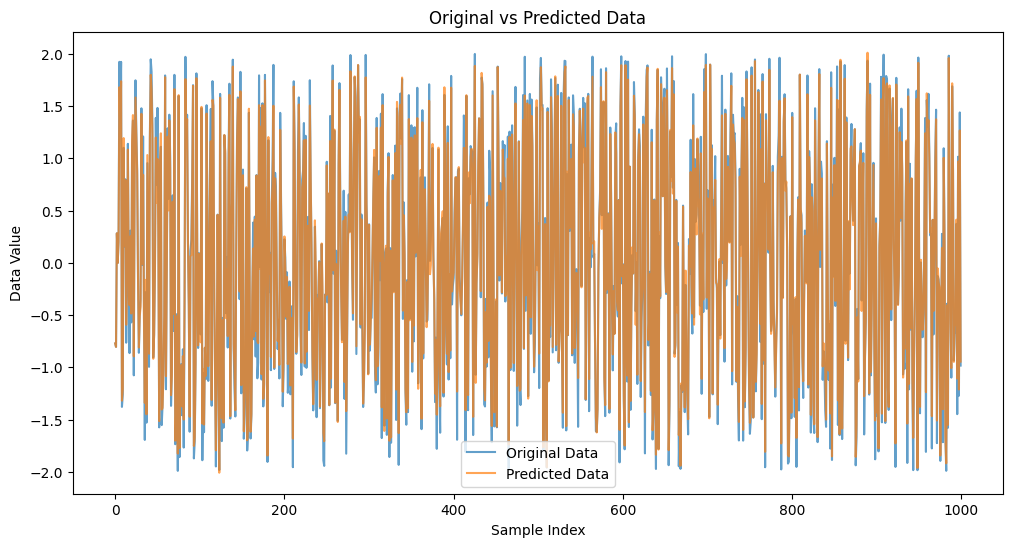

Maximum Error: 0.5712561227413313
Mean Squared Error: 0.01623217767775274
Compression Ratio: 0.7756894091125325


In [12]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# 生成随机时序数据
data = np.random.uniform(-2, 2, 1000)

# 创建滞后特征
def create_lagged_features(data, n_lags=5):
    X = []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
    return np.array(X)

n_lags = 5
X = create_lagged_features(data, n_lags)

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, data[n_lags:])

# 使用模型进行预测
predicted = model.predict(X)

# 构造完整的预测序列
# 前n_lags个数据无法预测，因此直接使用原始数据
predicted_full = np.concatenate([data[:n_lags], predicted])

# 计算误差
errors = data - predicted_full
max_error = np.max(np.abs(errors))
mean_squared_error = np.mean(np.square(errors))

# 展示原始数据和解压（预测）后数据的对比
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data', alpha=0.7)
plt.plot(predicted_full, label='Predicted Data', alpha=0.7)
plt.legend()
plt.title('Original vs Predicted Data')
plt.xlabel('Sample Index')
plt.ylabel('Data Value')
plt.show()

# 输出误差信息
print("Maximum Error:", max_error)
print("Mean Squared Error:", mean_squared_error)

# 使用pickle模块序列化模型
import pickle
model_serialized = pickle.dumps(model)

# 计算压缩比
original_data_size = data.nbytes*32  # 原始数据的大小
model_size = len(model_serialized)  # 序列化后模型的大小
compression_ratio = original_data_size / model_size

print("Compression Ratio:", compression_ratio)


### 测试分层

In [13]:
import numpy as np
generated_list = np.random.uniform(-0.54, 0.54, 32)

In [14]:
print(generated_list)

[ 0.5179898  -0.20376446 -0.25869853 -0.4067091  -0.08892114 -0.09919838
 -0.10465554  0.44643064  0.46456209  0.39949996  0.1177289  -0.29988837
 -0.23761794  0.35873519 -0.41240213  0.08460566 -0.16862253 -0.51348996
 -0.34676398 -0.24166546 -0.09715825 -0.23423301 -0.17116219 -0.13122091
  0.00113473 -0.50992899  0.0378124  -0.4203663  -0.52885996  0.18357376
 -0.18766715 -0.38394041]


In [15]:
res = [0]
for i,v in enumerate(generated_list):
    if abs(v-res[-1])<=0.053:
        generated_list[i] = 0
print(generated_list)

[ 0.5179898  -0.20376446 -0.25869853 -0.4067091  -0.08892114 -0.09919838
 -0.10465554  0.44643064  0.46456209  0.39949996  0.1177289  -0.29988837
 -0.23761794  0.35873519 -0.41240213  0.08460566 -0.16862253 -0.51348996
 -0.34676398 -0.24166546 -0.09715825 -0.23423301 -0.17116219 -0.13122091
  0.         -0.50992899  0.         -0.4203663  -0.52885996  0.18357376
 -0.18766715 -0.38394041]


In [16]:
v1 = np.mean(generated_list[:16])
v2 = np.mean(generated_list[16:]) 
      
for i,v in enumerate(generated_list[:8]):
    if abs(v-v1 )<=0.053:
        generated_list[i] = 0
    else:
        generated_list[i] = v-v1 
for i,v in enumerate(generated_list[8:]):
    if abs(v-v2 )<=0.053:
        generated_list[i] = 0
    else:
        generated_list[i] = v-v2

res.append(v1)
res.append(v2)
print(generated_list)

[ 0.69903117  0.63396904  0.35219799 -0.06541929  0.          0.59320427
 -0.17793304  0.31907474  0.06584656 -0.27902088 -0.1122949   0.
  0.13731083  0.          0.06330689  0.10324818  0.23446908 -0.27545991
  0.23446908 -0.18589721 -0.29439087  0.41804285  0.         -0.14947132
  0.         -0.50992899  0.         -0.4203663  -0.52885996  0.18357376
 -0.18766715 -0.38394041]


In [17]:
print(res)

[0, 0.017356039951195976, -0.23446908324267077]


In [18]:
v1 = np.mean(generated_list[:8])
v2 = np.mean(generated_list[8:16])
v3 = np.mean(generated_list[16:24])
v4 = np.mean(generated_list[24:])


for i,v in enumerate(generated_list[:8]):
    if abs(v-v1 )<=0.053:
        generated_list[i] = 0
    else:
        generated_list[i] = v-v1 
for i,v in enumerate(generated_list[8:16]):
    if abs(v-v2 )<=0.053:
        generated_list[i] = 0
    else:
        generated_list[i] = v-v2
for i,v in enumerate(generated_list[16:24]):
    if abs(v-v3 )<=0.053:
        generated_list[i] = 0
    else:
        generated_list[i] = v-v3
for i,v in enumerate(generated_list[24:]):
    if abs(v-v4 )<=0.053:
        generated_list[i] = 0
    else:
        generated_list[i] = v-v4


res.append(v1)
res.append(v2)
res.append(v3)
res.append(v4)
print(generated_list)
print(res)

[ 0.23089863 -0.27903036  0.23089863 -0.18946767 -0.29796133  0.41447239
  0.         -0.15304178  0.06584656 -0.27902088 -0.1122949   0.
  0.13731083  0.          0.06330689  0.10324818  0.23446908 -0.27545991
  0.23446908 -0.18589721 -0.29439087  0.41804285  0.         -0.14947132
  0.         -0.50992899  0.         -0.4203663  -0.52885996  0.18357376
 -0.18766715 -0.38394041]
[0, 0.017356039951195976, -0.23446908324267077, 0.29426560976573685, -0.002700415075080745, -0.0022797876358243985, -0.23089862984268694]


In [19]:
index = 0
while index<=7:
    if((index+1)*4<32):
        l = generated_list[index*4:(index+1)*4]
    else:
        l = generated_list[index*4:]

    pool = np.mean(l)
    for i,v in enumerate(l):
        if abs(v-pool )<=0.053:
            l[i] = 0
        else:
            l[i] = v-pool
    if((index+1)*4<32):
        generated_list[index*4:(index+1)*4] = l[:]
    else:
        generated_list[index*4:] = l[:]

    index += 1 
    res.append(pool)

print(generated_list)
print(res)

[ 0.23257382 -0.27735517  0.23257382 -0.18779247 -0.28882865  0.42360507
  0.         -0.1439091   0.14721386 -0.19765357  0.          0.0813673
  0.06134436 -0.07596647  0.          0.          0.23257382 -0.27735517
  0.23257382 -0.18779247 -0.28793604  0.42449768  0.         -0.14301649
  0.23257382 -0.27735517  0.23257382 -0.18779247 -0.29963652  0.4127972
  0.         -0.15471697]
[0, 0.017356039951195976, -0.23446908324267077, 0.29426560976573685, -0.002700415075080745, -0.0022797876358243985, -0.23089862984268694, -0.0016751914101072463, -0.009132677311513265, -0.08136730496948386, 0.07596647481932237, 0.0018952619898765857, -0.006454837261525383, -0.2325738212527942, -0.22922343843257964]


In [20]:
import gorillacompression as gc
values = [p.value for p in residuals]
minVal = min(values)
values = [v-minVal for v in values]
content = gc.ValuesEncoder.encode_all(values)
#print(content)
print(len(content['encoded']))

8137421
